## Data Processing

In [1]:
import numpy as np
import tensorflow as tf
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP
import matplotlib.pyplot as plt
import time
import datetime
import random
import scipy.sparse as sp
from collections import defaultdict
import random


num_mol = 100000

with open('ZINC.smiles', 'r') as file:
    contents = file.readlines()
    print(len(contents))
    smi_total = []
    logP_total= []
    for i in range(num_mol):
        smi = contents[i].strip()
        mol = Chem.MolFromSmiles(smi)
        smi_total.append(smi)
        logP_total.append(MolLogP(mol))

    logP_total= np.array(logP_total).reshape(-1,1)



192734


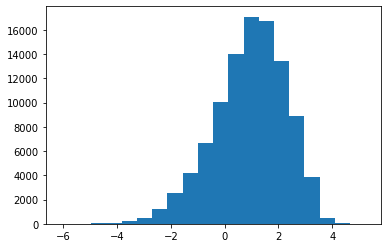

In [2]:
plt.hist(logP_total, bins = 20)
plt.show()

In [3]:
max_atom_n = 0
atom_species = defaultdict(int)
atom_degree = defaultdict(int)
atom_H_n = defaultdict(int)
atom_valence = defaultdict(int)

for smi in smi_total:
    mol = Chem.MolFromSmiles(smi.strip())
    
    adj = Chem.rdmolops.GetAdjacencyMatrix(mol)
    max_atom_n = max(adj.shape[0], max_atom_n)
    
    for atom in mol.GetAtoms():
        atom_species[atom.GetSymbol()] += 1
        atom_degree[atom.GetDegree()] += 1
        atom_H_n[atom.GetTotalNumHs()] += 1
        atom_valence[atom.GetImplicitValence()] += 1 

    
for inf in (max_atom_n, atom_degree, atom_H_n, atom_valence, atom_species):
    print(inf)

19
defaultdict(<class 'int'>, {1: 316826, 3: 443230, 2: 732489, 4: 16918})
defaultdict(<class 'int'>, {2: 305225, 0: 589767, 1: 447459, 3: 167012})
defaultdict(<class 'int'>, {2: 284794, 0: 653118, 1: 426879, 3: 144672})
defaultdict(<class 'int'>, {'N': 205291, 'C': 1121069, 'O': 142317, 'F': 19232, 'Cl': 8161, 'S': 11903, 'Br': 1455, 'I': 35})


In [4]:
def atom_feature(atom):
    features =  list(map(lambda s: int(atom.GetDegree() == s), [1, 2, 3, 4])) + \
                list(map(lambda s: int(atom.GetTotalNumHs() == s), [0, 1, 2, 3])) + \
                list(map(lambda s: int(atom.GetImplicitValence() == s), [0, 1, 2, 3,])) + \
                list(map(lambda s: int(atom.GetSymbol() == s), ['C', 'N', 'O', 'S', 'F', 'Cl', 'Br','I',])) + \
                [atom.GetIsAromatic()]

    return np.array(features)


num_features = len(atom_feature(atom))
print(num_features)

21


In [5]:
def smi_to_feat_adj(smiles_list, num_features):
    all_adj = []
    all_features = []
    all_index = []
    
    for smi in smiles_list:
        mol = Chem.MolFromSmiles(smi.strip())
        adj = Chem.rdmolops.GetAdjacencyMatrix(mol)
        adj = sp.csr_matrix(np.array(adj, dtype='int64')).tocsr()

        feature = []
        for atom in mol.GetAtoms():
            feature.append( atom_feature(atom) ) 

        all_features.append(np.array(feature))
        all_adj.append(adj)
        all_index.append(len(feature))
    
    all_index = np.repeat(np.arange(len(all_index)), all_index)

    #to tensor
    all_adj = sp.block_diag(all_adj)
    all_adj = tf.SparseTensor(
        indices=np.array([all_adj.row, all_adj.col]).T,
        values=all_adj.data,
        dense_shape=all_adj.shape    
    )
    
    all_features = np.vstack(all_features)
    all_features = tf.convert_to_tensor(all_features)
    
    all_index  = tf.convert_to_tensor(all_index)
    return all_features, all_adj, all_index


In [6]:
num_train = 80000
num_validation = 10000
num_test = 10000

smi_train = smi_total[0:num_train]
logP_train = logP_total[0:num_train]
smi_validation = smi_total[num_train:(num_train+num_validation)]
logP_validation = logP_total[num_train:(num_train+num_validation)]
smi_test = smi_total[(num_train+num_validation):]
logP_test = logP_total[(num_train+num_validation):]

def data_batchs(smi_list, logP, batch_size):
    logP = tf.convert_to_tensor(logP)
    i = 0
    X, A, I, y = [], [], [], []
    
    while i < len(smi_list):

        batch_features, batch_adj, batch_index = smi_to_feat_adj(smi_list[i:i+batch_size], num_features)
        X.append(batch_features)
        A.append(batch_adj)
        I.append(batch_index)
        y.append(logP[i:i+batch_size])

        i += batch_size
    
    return X, A, I, y

X_train, A_train, I_train, logP_train = data_batchs(smi_train, logP_train, 25)
X_validation, A_validation, I_validation, logP_validation = data_batchs(smi_validation, logP_validation, 500)
X_test, A_test, I_test, logP_test = data_batchs(smi_test, logP_test, 500)


## Model Building

In [7]:
from tensorflow.keras.layers import Input, Dense, Layer, Dropout
from tensorflow.keras import activations, initializers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MSE

tf.__version__

class Readout(Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.dense = Dense(units=self.units, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros',)    

    def call(self, input_X, input_I):
        output_Z = self.dense(input_X)
        output_Z = tf.math.segment_sum(output_Z, input_I)
        output_Z = tf.nn.sigmoid(output_Z)
        return output_Z    


class GatedGCN(Layer):
    def __init__(self, units=32, **kwargs):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.inp_dim = int(input_shape[-1])
        if(self.units != self.inp_dim):
            self.dense_i = Dense(
                units=self.units, 
                activation=None, 
                use_bias=True, 
                kernel_initializer='glorot_uniform', 
                bias_initializer='zeros',)

        self.dense_n = Dense(units=self.units, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros',)    
        
        self.dense_gate_n = Dense(units=self.units, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros',)
        
        self.dense_gate_i = Dense(units=self.units, 
                             activation=None, 
                             use_bias=True, 
                             kernel_initializer='glorot_uniform', 
                             bias_initializer='zeros',)

    def call(self, input_X, input_A):
        new_X = self.dense_n(input_X)
        new_X = tf.sparse.sparse_dense_matmul(input_A, new_X)
        
        X1 = self.dense_gate_i(input_X)
        X2 = self.dense_gate_n(new_X)
        gate_coefficient = tf.nn.sigmoid(X1 + X2)

        if(self.units != self.inp_dim):
            input_X = self.dense_i(input_X)
            
        output_X = tf.multiply(new_X, gate_coefficient) + tf.multiply(input_X, 1.0-gate_coefficient)        
        
        return output_X
    

In [8]:
num_features=21

num_layer = 4
hidden_dim1 = 64
hidden_dim2 = 256
init_lr = 0.0001

X = Input(shape=(num_features,))
A = Input(shape=(None,), sparse=True)
I = Input(shape=(), dtype=tf.int64)

h = X

for i in range(num_layer):
    h = GatedGCN(units=hidden_dim1)(h, A)

h = Readout(units=hidden_dim2)(h, I) 

h = Dense(units=hidden_dim2, use_bias=True, activation='relu')(h)
h = Dense(units=hidden_dim2, use_bias=True, activation='tanh')(h)
h = Dropout(0.5)(h)
Y_pred = Dense(units=1, use_bias=True)(h)

model = Model(inputs=[X, A, I], outputs=Y_pred)
optimizer = Adam(lr=init_lr)
model.compile(optimizer=optimizer, loss='mse')
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
gated_gcn (GatedGCN)            (None, 64)           8384        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
gated_gcn_1 (GatedGCN)          (None, 64)           12480       gated_gcn[0][0]       

## Training and Testing

In [9]:

@tf.function(experimental_relax_shapes=True)
def train_step(x, a, i, y):
    with tf.GradientTape() as tape:
        predictions = model([x, a, i], training=True)
        loss = MSE(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return tf.reduce_mean(loss)

@tf.function(experimental_relax_shapes=True)
def test_step(x, a, i, y):
    predictions = model([x, a, i], training=False)
    loss = MSE(y, predictions)
    return tf.reduce_mean(loss)


In [10]:

epochs = 50

try:
    for epoch_n in range(epochs):
        epoch_loss = 0
        batch_n = 0
        for x, a, i, y in zip(X_train, A_train, I_train, logP_train):
            loss = train_step(x, a, i, y)
            epoch_loss += loss
            batch_n += 1

            if batch_n == len(X_train):

                val_loss = 0
                val_n = 0
                for x, a, i, y in zip(X_validation, A_validation, I_validation, logP_validation):
                    val_loss += test_step(x, a, i, y)
                    val_n += 1
                print(f'Epoch:{epoch_n}   Loss:{epoch_loss/len(X_train):.3f}   val_Loss:{val_loss/val_n:.3f}')
                epoch_loss = 0
                batch_n = 0

                # shuffle
                c = list(zip(X_train, A_train, I_train, logP_train))
                random.shuffle(c)
                X_train, A_train, I_train, logP_train = zip(*c)

except:
    print('Early stoping')
    

Epoch:0   Loss:0.364   val_Loss:0.192
Epoch:1   Loss:0.126   val_Loss:0.102
Epoch:2   Loss:0.089   val_Loss:0.067
Epoch:3   Loss:0.072   val_Loss:0.070
Epoch:4   Loss:0.061   val_Loss:0.050
Epoch:5   Loss:0.052   val_Loss:0.040
Epoch:6   Loss:0.048   val_Loss:0.046
Epoch:7   Loss:0.043   val_Loss:0.034
Epoch:8   Loss:0.039   val_Loss:0.037
Epoch:9   Loss:0.037   val_Loss:0.028
Epoch:10   Loss:0.035   val_Loss:0.029
Epoch:11   Loss:0.032   val_Loss:0.025
Epoch:12   Loss:0.030   val_Loss:0.020
Epoch:13   Loss:0.030   val_Loss:0.021
Epoch:14   Loss:0.027   val_Loss:0.022
Epoch:15   Loss:0.028   val_Loss:0.021
Epoch:16   Loss:0.025   val_Loss:0.023
Epoch:17   Loss:0.024   val_Loss:0.023
Epoch:18   Loss:0.023   val_Loss:0.014
Epoch:19   Loss:0.023   val_Loss:0.020
Epoch:20   Loss:0.022   val_Loss:0.016
Epoch:21   Loss:0.022   val_Loss:0.018
Epoch:22   Loss:0.021   val_Loss:0.016
Epoch:23   Loss:0.020   val_Loss:0.013
Epoch:24   Loss:0.020   val_Loss:0.014
Epoch:25   Loss:0.020   val_Loss:0.

In [12]:
test_n, test_loss = 0, 0
for x, a, i, y in zip(X_test, A_test, I_test, logP_test):
    test_loss += test_step(x, a, i, y)
    test_n += 1
print(f'test_Loss:{test_loss/test_n:.3f}')

test_Loss:0.009


In [14]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to add
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))
    
for name, val in globals().items():
    if isinstance(val, types.ModuleType):
        print(val.__name__)

tensorflow==2.3.1
scipy==1.3.1
numpy==1.19.1
matplotlib==3.1.1
builtins
builtins
numpy
tensorflow
rdkit.Chem
rdkit.DataStructs
rdkit.Chem.AllChem
matplotlib.pyplot
time
datetime
random
scipy.sparse
tensorflow.keras.activations
tensorflow.keras.initializers
pkg_resources
types
